# 🙎‍♀️ 인물모드 사진 만들기
**"아웃포커싱 처리된 사진을 만들어보는 프로젝트"**

#### 😉 목차

1. 사진 불러오기
2. 이미지 세그멘테이션
3. 결과 도출
 - 사람 사진
 - 강아지 사진
 - 배경전환 크로마키 사진
4. 문제점 분석
5. 회고 및 문제점 해결방안

---

#### 모듈

In [1]:
import os

import cv2
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import tarfile
import urllib # 웹에서 데이터 다운로드

from IPython.display import Image

## 1 사진 불러오기

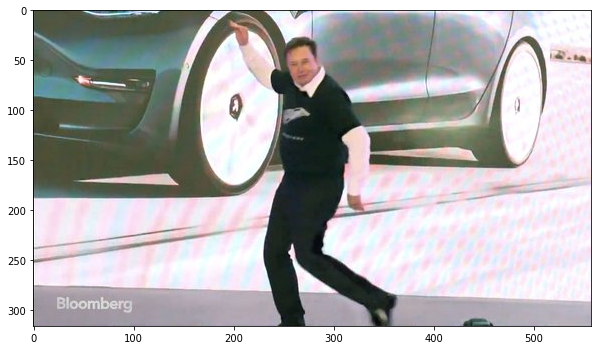

In [2]:
img_path = os.getenv('HOME')+'/aiffel/aiffel_exploration/E08/my_image.jpg' 
img_orig = cv2.imread(img_path) 

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

> 예시로 적당한 사진을 불러왔습니다.(인물과 배경이 잘 구분되는 사진 / 신난 일론머스크.jpg)

## 2 이미지 세그멘테이션
- 이미지에서 픽셀 단위로 객체를 추출하는 방법
- 여러 모델 중 DeepLab 사용

### 2-1 DeepLab 모델 구현

In [3]:
# 여러 세그멘테이션 모델 중 DeepLab 모델 구현
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지 -> Numpy array 전환하는 함수
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
    # 실행 함수
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 2-2 DeepLab용 가중치

In [4]:
# DeepLab용 가중치 다운로드(구글 데이터)
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/aiffel_exploration/E08/models'
tf.io.gfile.makedirs(model_dir) # 디렉토리 생성

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

# 모델 구현
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/aiffel_exploration/E08/models
model loaded successfully!


### 2-3 DeepLab용 라벨 이름

In [5]:
# DeepLab 라벨 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
print(f"클래스 수: {len(LABEL_NAMES)}개")

클래스 수: 21개


---

## 3 결과 도출

### 3-1 사람 사진
1. 하나의 사진을 2개의 버전으로 분리
2. 사진v1: 사람 영역 검출
3. 사진v2: 전체 흐리게, 배경 영역 검출
4. 사진v1(사람 영역) + 사진v2(배경 영역) = 배경은 흐리고 사람은 또렷한 사진 획득 

In [6]:
# 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig) # 이미지 리사이즈
print ("원본 사진 크기: {}\n리사이즈 사진 크기: {}\n라벨: {}".format(img_orig.shape, img_resized.shape, seg_map.max()))

원본 사진 크기: (316, 558, 3)
리사이즈 사진 크기: (290, 513, 3)
라벨: 15


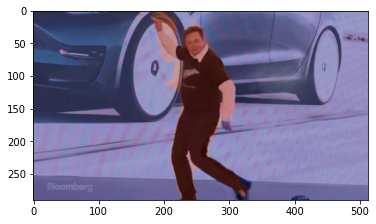

In [7]:
#  사람 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

> 음.. 경계를 제대로 못 잡는 부분이 있는것 같은데..? 뒤에서 정리하자.

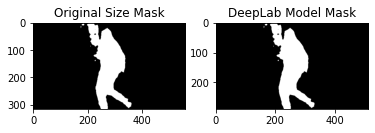

In [8]:
# 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

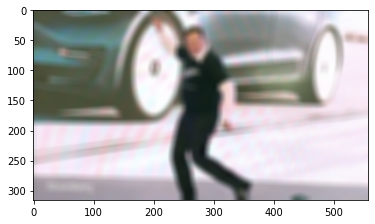

In [9]:
# 배경 흐리게하기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

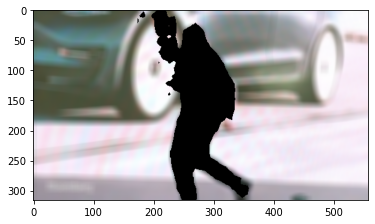

In [10]:
# 세그멘테이션 마스크를 이용하여 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전(배경: 255, 사람: 0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

> 왼손은 왜 포함하지 않는걸까..? 뒤에서 정리하자.

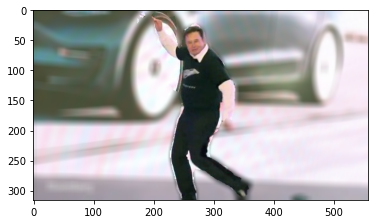

In [11]:
# 배경+사람 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 중간중간 아쉬운 부분이 있었지만 결과는 나름대로 잘 나온 것을 확인할 수 있다.

### 3-2 강아지 사진

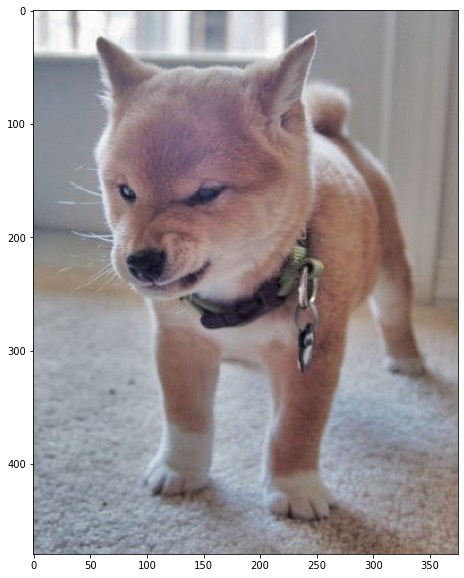

In [12]:
# 경로 설정
doge_img_path = os.getenv('HOME')+'/aiffel/aiffel_exploration/E08/doge.jpg' 
doge_img_orig = cv2.imread(doge_img_path) 

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(doge_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
# 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(doge_img_orig) # 이미지 리사이즈
print ("원본 사진 크기: {}\n리사이즈 사진 크기: {}\n라벨: {}".format(img_orig.shape, img_resized.shape, seg_map.max()))

원본 사진 크기: (316, 558, 3)
리사이즈 사진 크기: (513, 400, 3)
라벨: 12


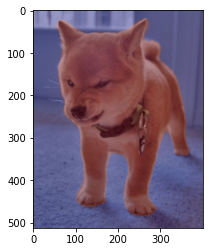

In [14]:
#  강아지 라벨(12)를 가진 영역만 검출하기
doge_img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 강아지만 추출
doge_img_mask = seg_map * (255/seg_map.max()) # 정규화
doge_img_mask = doge_img_mask.astype(np.uint8)
doge_color_mask = cv2.applyColorMap(doge_img_mask, cv2.COLORMAP_JET)
doge_img_show = cv2.addWeighted(doge_img_show, 0.6, doge_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(doge_img_show, cv2.COLOR_BGR2RGB))
plt.show()

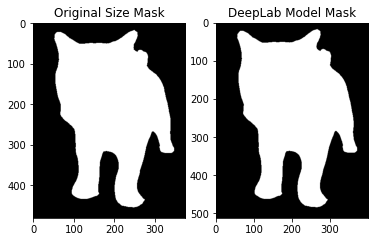

In [15]:
# 세그멘테이션 결과를 원래 크기로 복원
doge_img_mask_up = cv2.resize(doge_img_mask, doge_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, doge_img_mask_up = cv2.threshold(doge_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(doge_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(doge_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

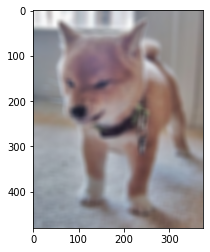

In [16]:
# 배경 흐리게하기
doge_img_orig_blur = cv2.blur(doge_img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(doge_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

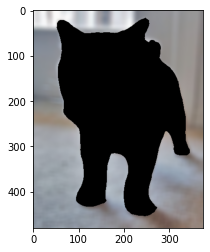

In [17]:
# 세그멘테이션 마스크를 이용하여 배경만 추출
doge_img_mask_color = cv2.cvtColor(doge_img_mask_up, cv2.COLOR_GRAY2BGR)
doge_img_bg_mask = cv2.bitwise_not(doge_img_mask_color) # 이미지 반전(배경: 255, 사람: 0)
doge_img_bg_blur = cv2.bitwise_and(doge_img_orig_blur, doge_img_bg_mask)
plt.imshow(cv2.cvtColor(doge_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

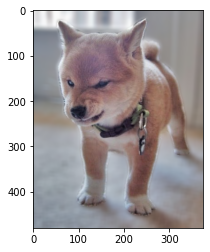

In [18]:
# 배경+강아지 합치기
doge_img_concat = np.where(doge_img_mask_color==255, doge_img_orig, doge_img_bg_blur)
plt.imshow(cv2.cvtColor(doge_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 사람에 비해 자연스러운 이미지를 얻었다! 아마 털이 자연스럽게 경계선에 블러 효과를 가져온 듯하다..!

### 3-3 배경전환 크로마키 사진

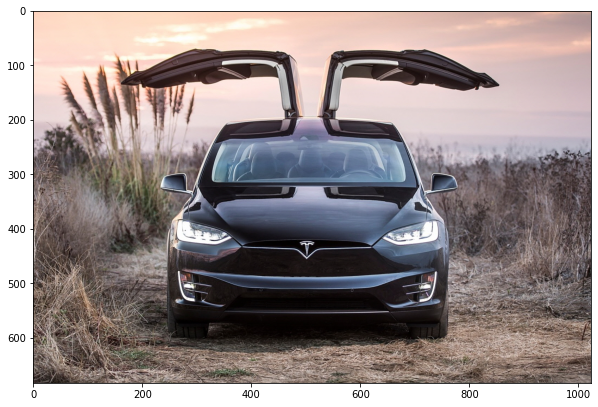

In [19]:
# 배경사진 경로 설정
model_X_img_path = os.getenv('HOME')+'/aiffel/aiffel_exploration/E08/model_X.jpg' 
model_X_img_orig = cv2.imread(model_X_img_path) 

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(model_X_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

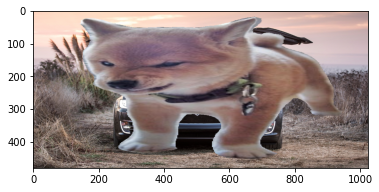

In [20]:
# 강아지사진, 배경사진 리사이즈
doge_img_resized = cv2.resize(doge_img_orig, (model_X_img_orig.shape[1], doge_img_orig.shape[0]))
model_X_img_resized = cv2.resize(model_X_img_orig, (model_X_img_orig.shape[1], doge_img_orig.shape[0]))
doge_img_mask_resized = cv2.resize(doge_img_mask_color, (model_X_img_orig.shape[1], doge_img_orig.shape[0]))

# 배경 영상과 고양이 영상을 합치기
doge_model_X_concat = np.where(doge_img_mask_resized == 255, doge_img_resized, model_X_img_resized)

plt.imshow(cv2.cvtColor(doge_model_X_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 도지가 곧 테슬라의 가치를 넘어설 것을 암시하는 작품. 하지만 아직은 테슬라가 건재하므로 도지의 크기를 약간 줄여 보겠습니다.

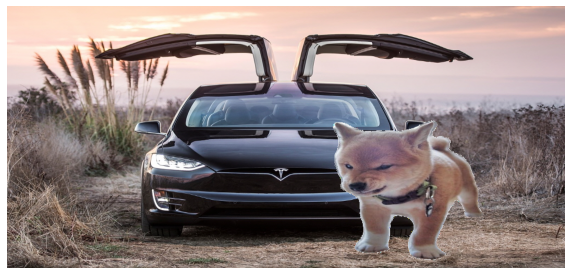

In [21]:
# 강아지 사진 추출
doge = np.where(doge_img_mask_color==255, doge_img_orig, 255)
doge = cv2.resize(doge, dsize=(350, 280), interpolation=cv2.INTER_CUBIC)

# 사진 위치지정, 리사이즈, 배경과 합성
refined_y = 200
refined_x = 550

sticker_area = model_X_img_resized[refined_y:refined_y+doge.shape[0], refined_x:refined_x+doge.shape[1]]
model_X_img_resized[refined_y:refined_y+doge.shape[0], refined_x:refined_x+doge.shape[1]] = np.where(doge==255,sticker_area, doge).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(model_X_img_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

> 함께 성장하는 도지와 테슬라를 응원합니다.

---

## 4 문제점 분석

1. 배경과 이미지의 경계선이 두드러져 사진이 어색함
2. 배경을 이미지 혹은 이미지를 배경으로 인식하는 부분 존재

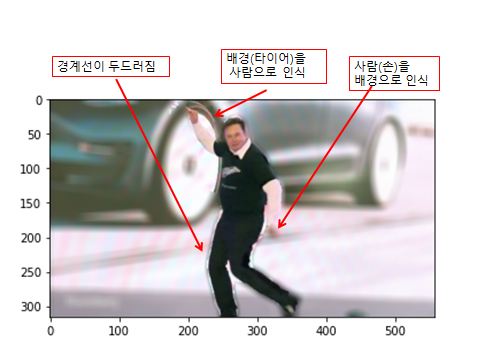

In [22]:
Image("my_image2.png")

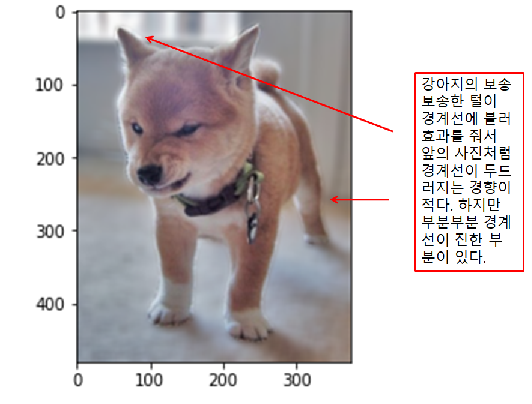

In [23]:
Image("my_image3.png")

---

## 5 회고 및 문제점 해결방안

- **타임라인**

1. 사진을 불러오고, 이미지 세그멘테이션을 통해 객체가 아웃포커싱된 사진을 여러장 제작해 보았다.
2. 이미지 세그멘테이션의 경우 DeepLab을 이용하였고, 이외에 시도해볼 수 있는 다른 모델은 FCN, SegNet, U-Net 등이 있다.
3. 비교적 간결한 코드만으로 뛰어난 결과를 가져올 수 있었지만 세부적인 부분에서 아쉬운점이 있다.
4. 주요한 두가지 문제는 **경계선이 너무 두드러진다는 것**, 그리고 **배경과 객체의 인식에 대한 정확도** 부분이다.

<br>

- **문제점 해결방안**

**경계선을 자연스럽게 하는 방안**    
>포토샵에서는 배경과 객체의 경계를 흐리게하기 위해서 가우시안블러라는 툴을 이용한다. 가우시안블러를 코드로 구현할 수 있다면 어느정도 경계를 자연스럽게 보여주는 효과가 있을 것으로 생각된다.

**배경과 객체의 인식률을 높이는 방안**    
>우선 DeepLab모델의 작동원리에 대한 조금 더 깊은 이해가 필요하다. 이를 통해 내가 원하는 객체만을 뚜렷하게 구분할 수 있는 파라미터를 조정해주는 방법이 있을 것으로 생각된다. 혹은 DeepLab이외의 FCN, SegNet, U-Net모델을 사용해 인물사진 모드를 구현해보고 결과값에 대한 차이를 비교하여 문제를 해결해 볼 수 있다고 생각한다.